In [506]:
import numpy as np
import pandas as  pd
import tensorflow as tf
from tensorflow import keras
#import keras
import matplotlib.pyplot as plt 
from tensorflow.keras import layers
from sklearn import *
import math
from sklearn.preprocessing import OrdinalEncoder
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split


## Import Data


In [507]:
#load the dataset
data = pd.read_csv('cancer_reg.csv', encoding='latin-1')

In [508]:
data = data.dropna()

In [509]:
y = data['TARGET_deathRate']

In [510]:
X = data.drop(columns=['binnedInc', 'TARGET_deathRate', 'Geography'])

In [511]:
data

,avgAnnCount,avgDeathsPerYear,TARGET_deathRate,incidenceRate,medIncome,popEst2015,povertyPercent,studyPerCap,binnedInc,MedianAge,...,PctPrivateCoverageAlone,PctEmpPrivCoverage,PctPublicCoverage,PctPublicCoverageAlone,PctWhite,PctBlack,PctAsian,PctOtherRace,PctMarriedHouseholds,BirthRate
1,173.000000,70,161.3,411.600000,48127,43269,18.6,23.111234,"(48021.6, 51046.4]",33.0,...,53.8,43.6,31.1,15.3,89.228509,0.969102,2.246233,3.741352,45.372500,4.333096
3,427.000000,202,194.8,430.400000,44243,75882,17.1,342.637253,"(42724.4, 45201]",42.8,...,40.3,35.0,45.3,25.0,91.744686,0.782626,1.161359,1.362643,51.021514,4.603841
4,57.000000,26,144.4,350.100000,49955,10321,12.5,0.000000,"(48021.6, 51046.4]",48.3,...,43.9,35.1,44.0,22.7,94.104024,0.270192,0.665830,0.492135,54.027460,6.796657
7,146.000000,71,183.6,404.000000,40189,20848,17.8,0.000000,"(37413.8, 40362.7]",51.7,...,33.1,25.9,50.9,24.1,89.406636,0.305159,1.889077,2.286268,48.967033,5.889179
14,2265.000000,901,171.0,440.700000,50083,490945,16.3,462.373586,"(48021.6, 51046.4]",37.2,...,50.6,42.5,36.5,21.4,89.038167,1.827041,2.315986,1.033625,48.188377,5.355836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3033,1962.667684,7,209.6,453.549422,45353,1843,11.4,0.000000,"(45201, 48021.6]",45.7,...,52.7,43.9,32.2,9.2,97.960199,0.000000,0.547264,0.995025,57.780612,4.664723
3034,1962.667684,85,184.4,453.549422,45180,35788,15.0,1900.078239,"(42724.4, 45201]",38.2,...,52.3,46.2,34.4,17.4,87.718617,3.168048,1.610355,1.893068,50.730567,7.404551
3043,1962.667684,43,150.1,453.549422,48609,37118,18.8,377.175494,"(48021.6, 51046.4]",30.4,...,53.3,48.6,28.8,17.7,75.706245,2.326771,4.044920,14.130288,52.007937,8.186470
3044,1962.667684,46,153.9,453.549422,51144,34536,15.0,1968.959926,"(51046.4, 54545.6]",30.9,...,52.6,47.8,26.6,16.8,87.961629,2.313188,1.316472,5.680705,55.153949,7.809192


In [512]:
#split the features and labels into  train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)


In [513]:
from sklearn.preprocessing import RobustScaler

#rescale the data to be robust to outliers
scaler = RobustScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [514]:
X_train.shape

(354, 31)


## Create a sampling layer


In [515]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim)) # Parametrization trick
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon 

## Build the encoder


In [516]:
latent_dim = 2 # Latent Space dimension on the bottleneck
input_dim = X_train.shape[1]
Leaky_ReLu = keras.layers.LeakyReLU(alpha=0.01)

encoder_inputs = keras.Input(shape=( input_dim, ))
x = layers.Dense(3, activation=Leaky_ReLu)(encoder_inputs)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_30 (InputLayer)          [(None, 31)]         0           []                               
                                                                                                  
 dense_48 (Dense)               (None, 3)            96          ['input_30[0][0]']               
                                                                                                  
 z_mean (Dense)                 (None, 2)            8           ['dense_48[0][0]']               
                                                                                                  
 z_log_var (Dense)              (None, 2)            8           ['dense_48[0][0]']               
                                                                                            

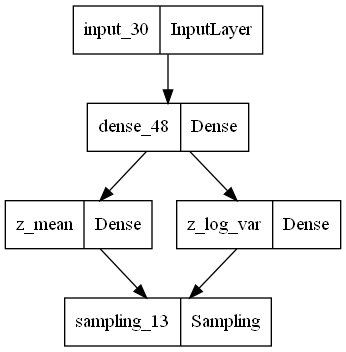

In [517]:
from keras.utils.vis_utils import plot_model
keras.utils.plot_model(encoder, to_file='encoder.png')

## Build the decoder


In [518]:
latent_inputs = keras.Input(shape=(latent_dim,))
#x = layers.Dense(5,  activation=Leaky_ReLu)(latent_inputs)
decoder_outputs = layers.Dense(1, activation="linear")(latent_inputs)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_31 (InputLayer)       [(None, 2)]               0         
                                                                 
 dense_49 (Dense)            (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


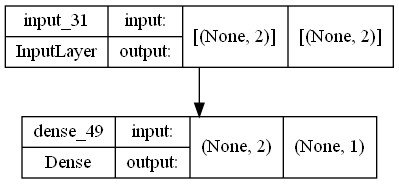

In [519]:
plot_model(decoder,  show_shapes=True, show_layer_names=True)

## Define the VAE as a Model with a custom train_step


In [520]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, KL_hyperparam, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.KL_hyperparam = KL_hyperparam
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")  #MEAN? 
        self.reconstruction_loss_tracker = keras.metrics.Mean(    #MEAN? 
            name="MSE"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")   #MEAN? 
        
        self.total_loss_tracker_val = keras.metrics.Mean(name="total_loss_val")  #MEAN? 
        self.reconstruction_loss_tracker_val = keras.metrics.Mean(    #MEAN? 
            name="MSE_val"
        )
        self.kl_loss_tracker_val = keras.metrics.Mean(name="kl_loss_val")   #MEAN? 

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            
            self.total_loss_tracker_val,
            self.reconstruction_loss_tracker_val,
            self.kl_loss_tracker_val
        ]

    def train_step(self, data):
        x, y_true = data
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(x)
            reconstruction = self.decoder(z)
            reconstruction_loss = keras.losses.mean_squared_error(y_true, reconstruction)
            
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            #kl_loss = tf.reduce_mean(kl_loss, axis=1)
            
            total_loss = reconstruction_loss + kl_loss * self.KL_hyperparam
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        self.total_loss_tracker.update_state(total_loss)
        
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "MSE": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        # Unpack the data
        x, y_true = data
        # Compute predictions
        z_mean, z_log_var, z = self.encoder(x)
        reconstruction = self.decoder(z)
        
        ## Losses
        reconstruction_loss = keras.losses.mean_squared_error(y_true, reconstruction)
        
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        
        total_loss = reconstruction_loss + kl_loss * self.KL_hyperparam

        # Updates the metrics tracking the loss
        self.total_loss_tracker_val.update_state(total_loss)
        
        self.reconstruction_loss_tracker_val.update_state(reconstruction_loss)
        
        self.kl_loss_tracker_val.update_state(kl_loss)
        
        return {
            "loss_val": self.total_loss_tracker_val.result(),
            "MSE_val": self.reconstruction_loss_tracker_val.result(),
            "kl_loss_val": self.kl_loss_tracker_val.result(),
        }



    def call(self, inputs):

        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
                


        return reconstruction
    


## Train the VAE

In [521]:
vae = VAE(encoder, decoder, 1)

In [522]:
from keras.optimizers import adam_v2
adam = adam_v2.Adam()




In [523]:
vae.compile(optimizer=adam)

In [574]:
history = vae.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=150, batch_size=14 )

Epoch 1/150
26/26 [==============================] - 0s 3ms/step - loss: 481.0562 - MSE: 276.0012 - kl_loss: 176.4837 - val_loss_val: 917.8135 - val_MSE_val: 744.4850 - val_kl_loss_val: 173.2626
Epoch 2/150
26/26 [==============================] - 0s 2ms/step - loss: 428.7324 - MSE: 270.1302 - kl_loss: 174.9800 - val_loss_val: 896.4556 - val_MSE_val: 721.6415 - val_kl_loss_val: 174.7477
Epoch 3/150
26/26 [==============================] - 0s 2ms/step - loss: 408.4227 - MSE: 266.4818 - kl_loss: 175.2440 - val_loss_val: 907.3591 - val_MSE_val: 733.6041 - val_kl_loss_val: 173.6898
Epoch 4/150
26/26 [==============================] - 0s 2ms/step - loss: 430.9745 - MSE: 269.8640 - kl_loss: 175.2863 - val_loss_val: 905.5809 - val_MSE_val: 732.3940 - val_kl_loss_val: 173.1216
Epoch 5/150
26/26 [==============================] - 0s 2ms/step - loss: 414.5988 - MSE: 267.6447 - kl_loss: 173.5056 - val_loss_val: 902.0685 - val_MSE_val: 728.9857 - val_kl_loss_val: 173.0144
Epoch 6/150
26/26 [======

Epoch 43/150
26/26 [==============================] - 0s 2ms/step - loss: 424.9819 - MSE: 255.8165 - kl_loss: 162.5897 - val_loss_val: 827.8077 - val_MSE_val: 666.9115 - val_kl_loss_val: 160.8332
Epoch 44/150
26/26 [==============================] - 0s 2ms/step - loss: 422.1879 - MSE: 254.7863 - kl_loss: 161.7530 - val_loss_val: 841.5401 - val_MSE_val: 680.5581 - val_kl_loss_val: 160.9160
Epoch 45/150
26/26 [==============================] - 0s 2ms/step - loss: 405.9414 - MSE: 257.7964 - kl_loss: 161.8560 - val_loss_val: 824.5776 - val_MSE_val: 664.0665 - val_kl_loss_val: 160.4469
Epoch 46/150
26/26 [==============================] - 0s 2ms/step - loss: 390.9487 - MSE: 259.2059 - kl_loss: 161.9998 - val_loss_val: 815.9861 - val_MSE_val: 656.4805 - val_kl_loss_val: 159.4439
Epoch 47/150
26/26 [==============================] - 0s 2ms/step - loss: 402.8444 - MSE: 258.2336 - kl_loss: 160.5960 - val_loss_val: 818.9022 - val_MSE_val: 659.6660 - val_kl_loss_val: 159.1728
Epoch 48/150
26/26 [

Epoch 85/150
26/26 [==============================] - 0s 2ms/step - loss: 418.0264 - MSE: 256.5319 - kl_loss: 153.6896 - val_loss_val: 788.4634 - val_MSE_val: 635.4171 - val_kl_loss_val: 152.9813
Epoch 86/150
26/26 [==============================] - 0s 2ms/step - loss: 407.8422 - MSE: 250.5026 - kl_loss: 153.3948 - val_loss_val: 773.1706 - val_MSE_val: 621.6831 - val_kl_loss_val: 151.4266
Epoch 87/150
26/26 [==============================] - 0s 2ms/step - loss: 368.9949 - MSE: 255.1294 - kl_loss: 153.4634 - val_loss_val: 773.6545 - val_MSE_val: 622.6867 - val_kl_loss_val: 150.9072
Epoch 88/150
26/26 [==============================] - 0s 2ms/step - loss: 397.0225 - MSE: 248.6546 - kl_loss: 152.1220 - val_loss_val: 777.3251 - val_MSE_val: 625.6362 - val_kl_loss_val: 151.6280
Epoch 89/150
26/26 [==============================] - 0s 2ms/step - loss: 397.5607 - MSE: 250.9879 - kl_loss: 153.8611 - val_loss_val: 768.7309 - val_MSE_val: 617.0603 - val_kl_loss_val: 151.6100
Epoch 90/150
26/26 [

Epoch 127/150
26/26 [==============================] - 0s 3ms/step - loss: 392.7135 - MSE: 250.9005 - kl_loss: 146.5831 - val_loss_val: 750.2807 - val_MSE_val: 606.5453 - val_kl_loss_val: 143.6784
Epoch 128/150
26/26 [==============================] - 0s 3ms/step - loss: 392.1495 - MSE: 252.5519 - kl_loss: 145.3453 - val_loss_val: 760.7617 - val_MSE_val: 615.5019 - val_kl_loss_val: 145.1998
Epoch 129/150
26/26 [==============================] - 0s 3ms/step - loss: 410.6506 - MSE: 253.1060 - kl_loss: 145.6890 - val_loss_val: 754.8871 - val_MSE_val: 609.9251 - val_kl_loss_val: 144.9024
Epoch 130/150
26/26 [==============================] - 0s 3ms/step - loss: 382.7600 - MSE: 255.1191 - kl_loss: 146.7783 - val_loss_val: 750.0787 - val_MSE_val: 606.7216 - val_kl_loss_val: 143.3007
Epoch 131/150
26/26 [==============================] - 0s 3ms/step - loss: 392.4976 - MSE: 250.4395 - kl_loss: 145.9172 - val_loss_val: 749.5035 - val_MSE_val: 605.1226 - val_kl_loss_val: 144.3226
Epoch 132/150
2

In [575]:
print(history.history.keys())

dict_keys(['loss', 'MSE', 'kl_loss', 'val_loss_val', 'val_MSE_val', 'val_kl_loss_val'])


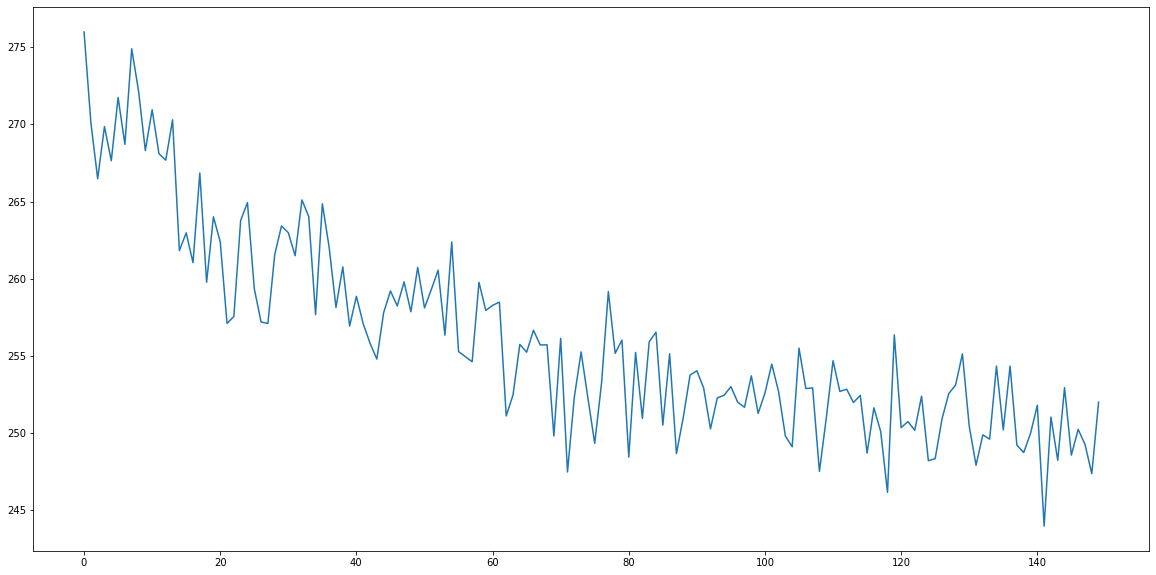

In [582]:
plt.plot(history.history['MSE'])


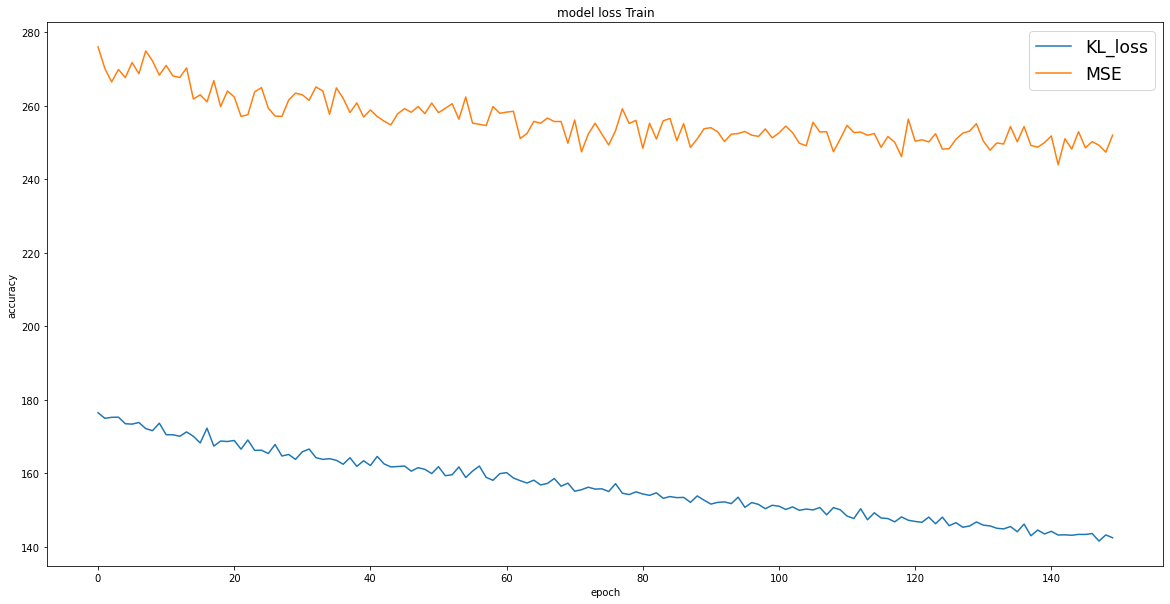

In [583]:
plt.plot(history.history['kl_loss'])
#plt.plot(history.history['val_total_loss'])
plt.title('model loss Train')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.plot(history.history['MSE'])
plt.legend(['KL_loss', 'MSE'], loc='upper right', fontsize ='xx-large')
plt.show()


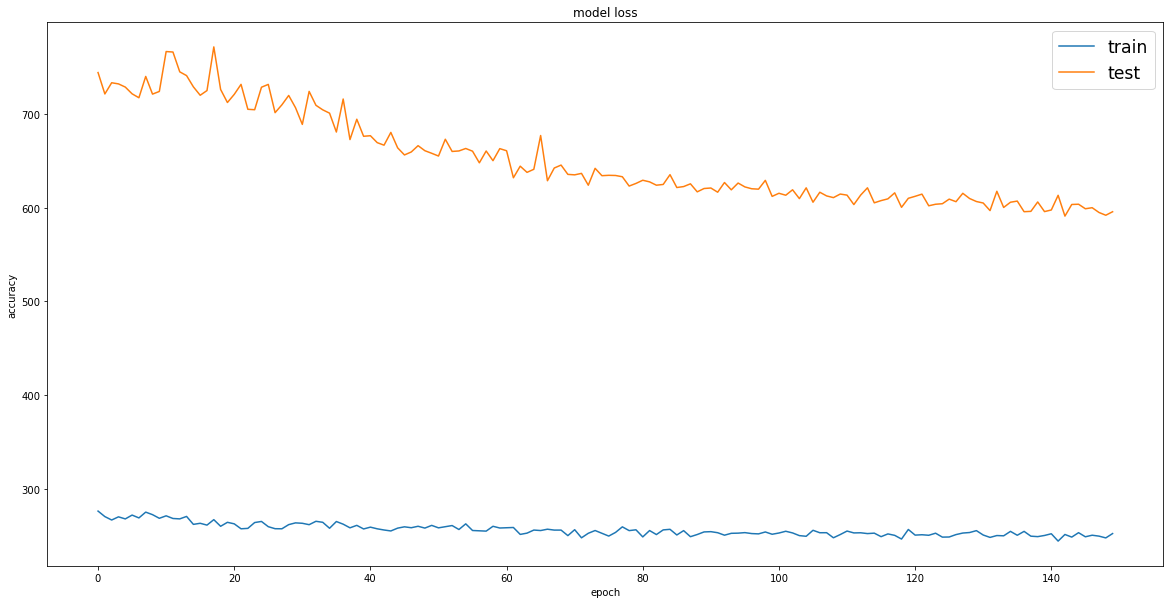

In [584]:
# summarize history for accuracy
plt.plot(history.history['MSE'])
#plt.plot(history.history['val_total_loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.plot(history.history['val_MSE_val'])

plt.legend(['train', 'test'], loc='upper right', fontsize ='xx-large')
plt.show()


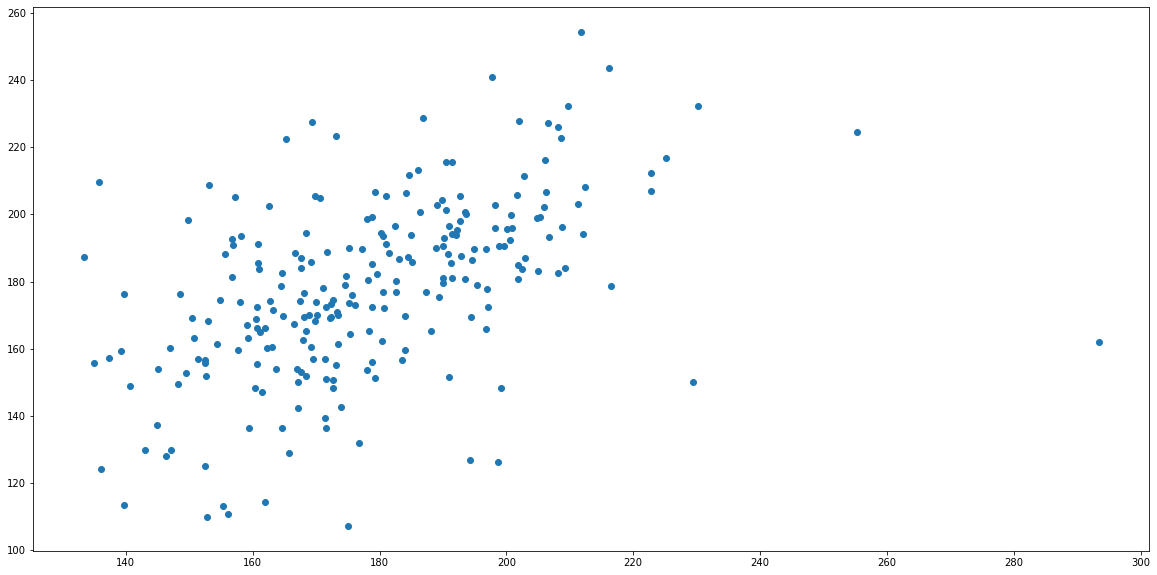

In [585]:
plt.scatter(vae.predict(X_test)[:], y_test[:])

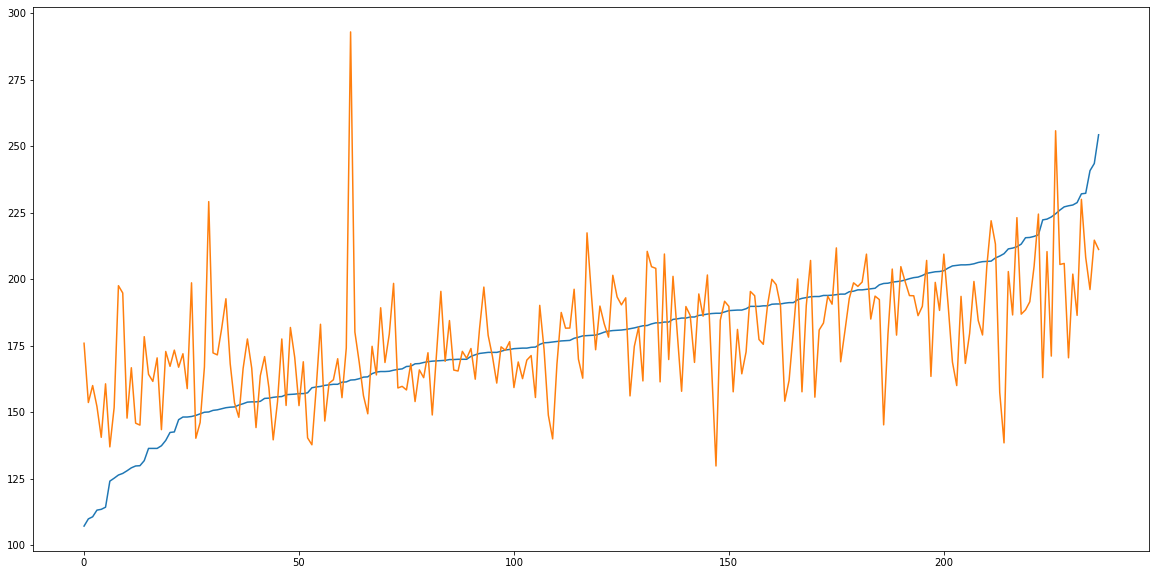

In [587]:
plt.plot(np.sort(y_test))

plt.plot(vae.predict(X_test)[np.argsort(y_test)])

In [588]:
def build_and_compile_model():
    model = keras.Sequential([
        
      keras.Input(shape=( input_dim, )),
      layers.Dense(64, activation='relu'),
      layers.Dense(32, activation='relu'),
      layers.Dense(1)
  
    ])

    model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
    return model

In [589]:
dnn_model = build_and_compile_model()


history = dnn_model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=1)



Epoch 1/30
354/354 [==============================] - 1s 1ms/step - loss: 23977.3281 - val_loss: 17604.3770
Epoch 2/30
354/354 [==============================] - 0s 1ms/step - loss: 8233.9043 - val_loss: 5672.7588
Epoch 3/30
354/354 [==============================] - 0s 1ms/step - loss: 3962.4700 - val_loss: 4118.4683
Epoch 4/30
354/354 [==============================] - 0s 1ms/step - loss: 2614.6299 - val_loss: 2788.0764
Epoch 5/30
354/354 [==============================] - 0s 1ms/step - loss: 1878.4269 - val_loss: 2302.1936
Epoch 6/30
354/354 [==============================] - 0s 1ms/step - loss: 1392.4548 - val_loss: 1954.0061
Epoch 7/30
354/354 [==============================] - 0s 1ms/step - loss: 1046.2830 - val_loss: 1873.2921
Epoch 8/30
354/354 [==============================] - 0s 1ms/step - loss: 854.2800 - val_loss: 1469.9264
Epoch 9/30
354/354 [==============================] - 0s 1ms/step - loss: 673.1569 - val_loss: 1574.7773
Epoch 10/30
354/354 [=========================

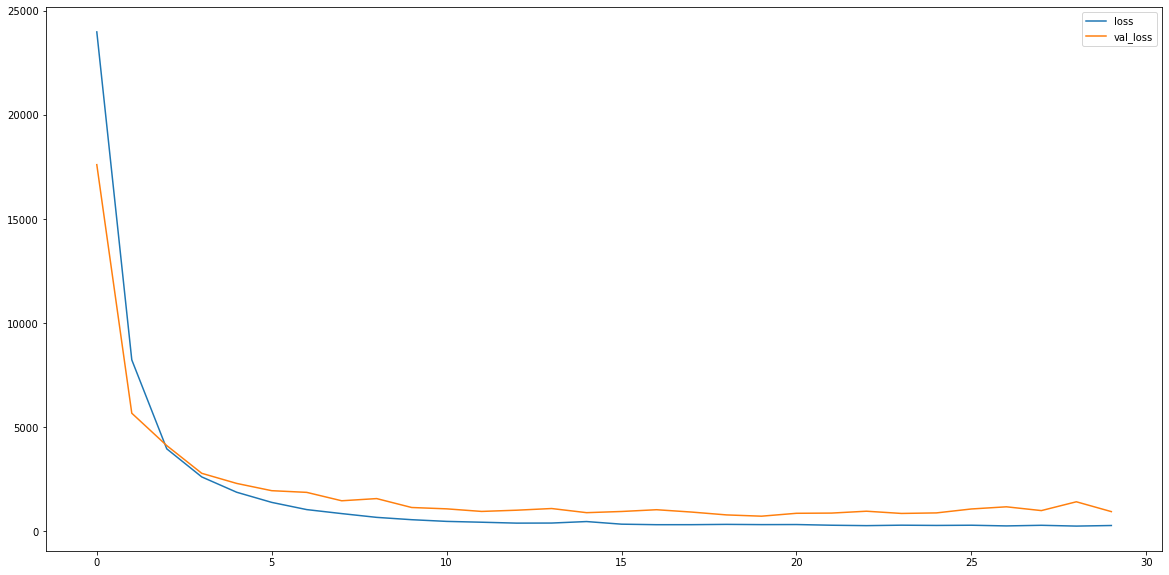

In [593]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()


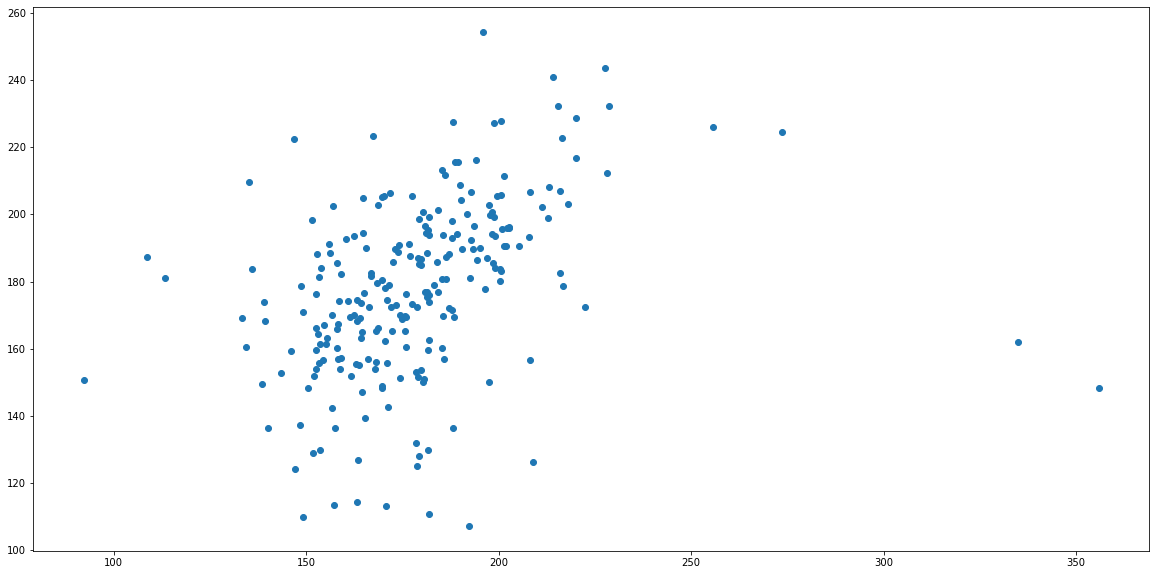

In [594]:
plt.scatter(dnn_model.predict(X_test)[:], y_test[:])

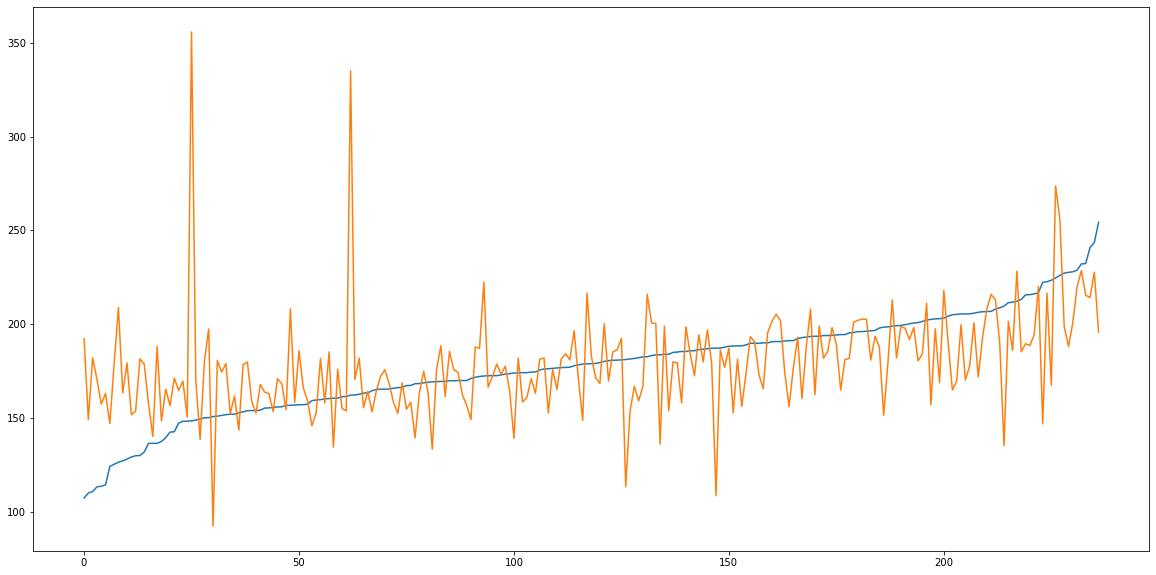

In [595]:
plt.plot(np.sort(y_test))

plt.plot(dnn_model.predict(X_test)[np.argsort(y_test)])